### Processes shared memory

Example: Convolution

In [12]:
img = pf.getdata("LB.20140623.37347.fits")
img.shape

(4096, 1155)

In [13]:
def rescale(img, k=1, maxVal=255.0):
    mean, std = img.mean(), img.std()
    scale = maxVal / (2 * k* std)
    bias = - scale * (mean - std * k)
    nImg = img * scale + bias
    return nImg.clip(0, maxVal)

<IPython.core.display.Javascript object>


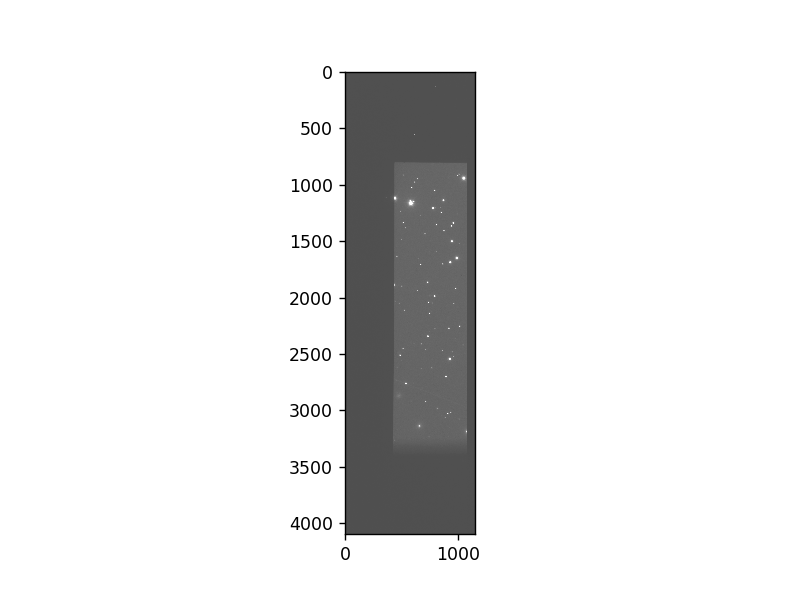

In [14]:
plt.figure()
plt.imshow(rescale(img), cmap='gray')

In [ ]:
plt.figure()
plt.imshow(rescale(imgCv), cmap='gray')

In [16]:
_dataOut = mp.Array(ctypes.c_double, img.size)
sharedDataOut = np.ctypeslib.as_array(_dataOut.get_obj()).reshape(img.shape)

In [17]:
def workerFunction (i):
    global sharedOutData, chunkSize
    margin =130
    sy = slice(i*chunkSize, (i+1)*chunkSize)
    s1 = i* chunkSize - margin
    s2 = slice (margin, -margin)
    if s1 < 0:
        s1 = 0
        s2 = slice(0, chunkSize)
    sy1 = slice(s1, (i+1)*chunkSize+margin)
    
    e1 = (i+1) * chunkSize + margin
    if e1 >= img.shape[0]:
        s2 = slice(min(s1, margin), chunkSize+margin, None)
    sharedDataOut[sy,:] = ndimage.filters.gaussian_filter(img[sy1,:], 33)[s2]

In [18]:
nParts = 6
chunkSize = img.shape[0]//nParts
sharedDataOut.fill(0)

In [19]:
%%timeit
# Test workerFunction, sequentially
for i in range(nParts):
    workerFunction (i)

7.59 s ± 214 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit
with mp.Pool(processes=nParts) as pool:
    pool.map(workerFunction, range(nParts))

2.66 s ± 863 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


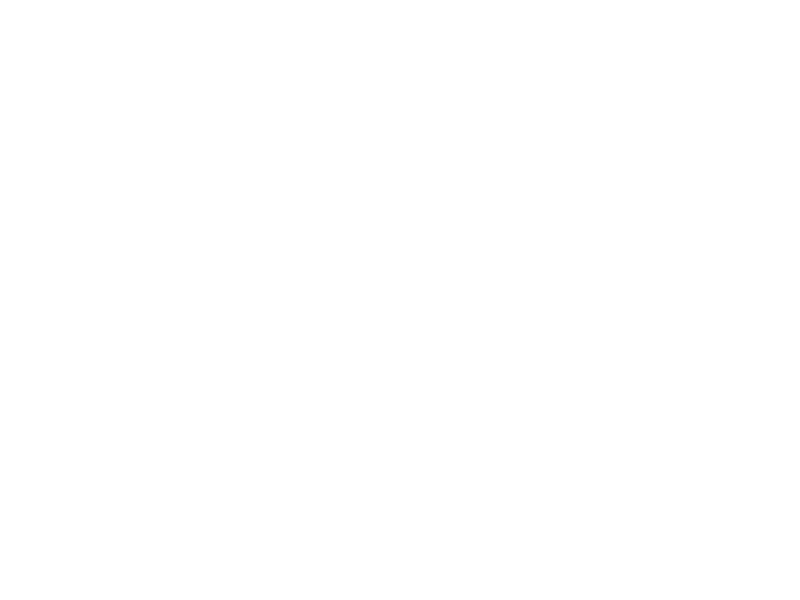

NameError: name 'imgCv' is not defined

In [9]:
plt.figure()
dImg = sharedDataOut - imgCv
plt.plot (dImg[:, dImg.shape[1]//2])
#plt.imshow(sharedDataOut-imgCv, cmap='gray')